In [1]:
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D, ClassicalImageTransform
from qcc.experiment import Experiment
from qcc.ml.model import Model

from pathlib import Path
from qcc.file import new_dir

# from qcc.quantum.pennylane.ansatz import MQCCOptimized as Module
# from qcc.ml.cnn import ConvolutionalNeuralNetwork as Module
from qcc.ml.hybrid_cnn import MQCCHybrid as Module

# from qcc.quantum.pennylane.ansatz.basic import BasicFiltering6
from qcc.quantum.pennylane.pyramid import Pyramid
from qcc.quantum.pennylane.c2q import ConvolutionAngleFilter, ConvolutionComplexAngleFilter, ConvolutionFilter
from qcc.quantum.pennylane.local import define_filter

INFO:qcc.ml.ml:Using CUDA on device cuda


In [3]:
# Meta parameters
name = "dhrsthrjnh"
filename = Path(f"results/{name}")
num_trials = 1
silent = False
is_quantum = False

# Ansatz parameters
dims = (16, 16, 1)
num_layers = 4
module_options = {
    # "U_filter": ConvolutionAngleFilter,
    # "pre_op": True,
    "num_features": 4,
    # "U_fully_connected": define_filter(num_layers=2),
    # # "pooling": True,
    # # "filter_shape": (2, 2, 2),
    # "q2c_method": "parity"
}

In [4]:
filename = new_dir(filename, overwrite=True)
filename = filename / name

if is_quantum:
    module = Module.from_dims
else:
    module = Module

# Create module
module = module(
    dims,
    num_layers=num_layers,
    **module_options,
)
data = BinaryData(
    FashionMNIST,
    ImageTransform(dims) if is_quantum else ClassicalImageTransform(dims),
    batch_size=(8,8),
)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
model = Model.with_logging(module, data, optimizer, loss, epoch=8)

# Log important values
model.logger.info(f"Circuit ID: {name}")
model.logger.info(f"{module=}")
model.logger.info(f"{data=}")
model.logger.info(f"{optimizer=}")
model.logger.info(f"{loss=}")

model.logger.info(f"{num_trials=}")
model.logger.info(f"{dims=}")
model.logger.info(f"{num_layers=}")
# model.logger.info(f"{1=}")
model.logger.info(f"{module_options=}")

# Save circuit drawing
if is_quantum:
    filename = filename.with_stem(f"{name}_circuit")
    module.draw(filename=filename, decompose=True)

INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 22
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 88
INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 8
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 29
INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 7
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 21
INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 6
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 15
2023-10-21 06:13:06,749: (mqcchybrid) Circuit ID: dhrsthrjnh
2023-10-21 06:13:06,749: (mqcchybrid) module=MQCCHybrid(
  (0): MQCCLayer(
    (mqcc): MQCC()
  )
  (1): ReLU()
  (2): MQCCLayer(
    (mqcc): MQCC()
  )
  (3): ReLU()
  (4): MQCCLayer(
    (mqcc): MQCC()
  )
  (5): ReLU()
  (6): MQCCLayer(
    (mqcc): MQCC()
  )
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4, out_features=2, bias=True)
)
2023-10-21 06:13:06,750: (mqcchybrid) data=BinaryData(dataset=<class 'torchvision.datasets.mnist.FashionMNIST'>, transform=image_transform_

In [5]:
# Run experiment
results_schema = ["accuracy", "training_time", "testing_time"]
experiment = Experiment(model, num_trials, results_schema)
# experiment.partial(silent=silent)
results = experiment(filename=filename)

2023-10-21 06:13:06,828: (mqcchybrid) Number of Parameters: 31
/home/mingyoungjeng/Documents/repos/quantum-convolutional-classifier/src/qcc/quantum/quantum.py:127: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  data = data.reshape(new_dims[::-1]).T
2023-10-21 06:15:14,701: (mqcchybrid) (Epoch 1) Training took 104.44450 sec
2023-10-21 06:15:31,354: (mqcchybrid) (Epoch 1) Testing took: 16.60945 sec
2023-10-21 06:15:31,354: (mqcchybrid) (Epoch 1) Accuracy: 96.750%
2023-10-21 06:17:51,149: (mqcchybrid) (Epoch 2) Training took 209.43690 sec
2023-10-21 06:18:07,839: (mqcchybrid) (Epoch 2) Testing took: 16.65999 sec
2023-10-21 06:18:07,840: (mqcchybrid) (Epoch 2) Accuracy: 97.000%


2023-10-21 06:33:18,917: (mqcchybrid) accuracy: median=0.9740000367164612, mean=0.9740000367164612, max=0.9740000367164612, min=0.9740000367164612, std=None
2023-10-21 06:33:18,918: (mqcchybrid) training_time: median=824.6780282849999, mean=824.6780282849999, max=824.6780282849999, min=824.6780282849999, std=None
2023-10-21 06:33:18,918: (mqcchybrid) testing_time: median=15.938862497999935, mean=15.938862497999935, max=15.938862497999935, min=15.938862497999935, std=None


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

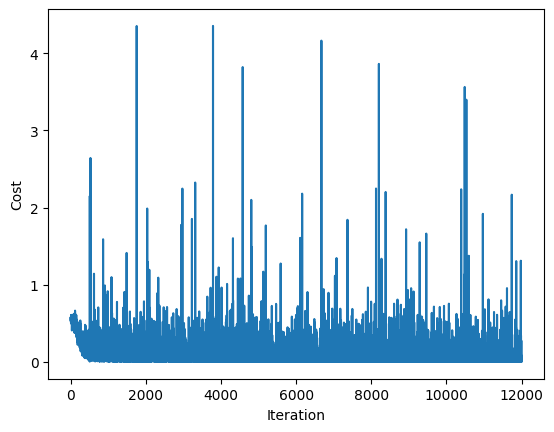

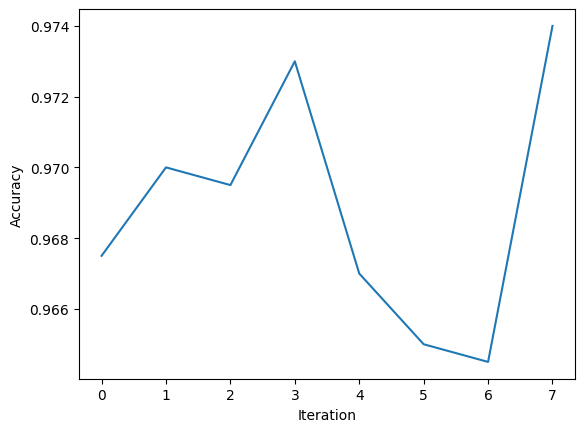

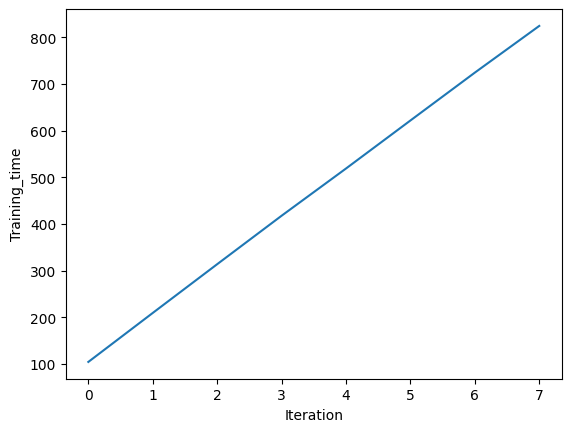

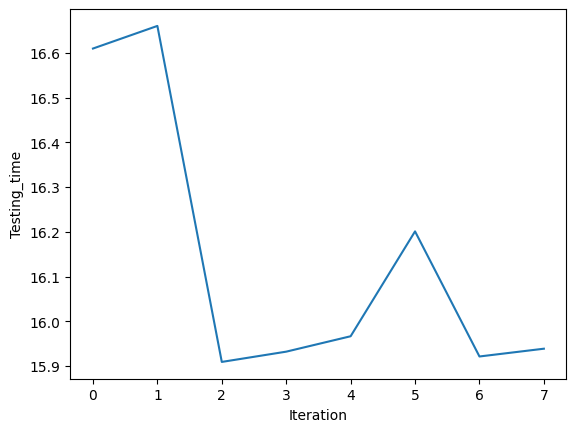

In [6]:
# Print accuracy results
metrics = ("median", "mean", "max", "min", "std")
for name in results.columns:
    col = results[name]
    msg = (f"{metric}={getattr(col, metric)()}" for metric in metrics)
    msg = ", ".join(msg)
    msg = f"{name}: {msg}"
    model.logger.info(msg)

# Save aggregated loss history figure
display(experiment.draw(filename))